In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import os

import numpy as np
import pandas as pd
# Torch
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib

In [7]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Apply transformations to augment data

In [8]:
transformer = transforms.Compose([
    # Resize the image to (160, 160)
    transforms.Resize((160, 160)),
    # Convert the image to grayscale only one channel
    transforms.Grayscale(num_output_channels=1),

    #Data Augmentation
    #Randomly flip the image horizontally
    transforms.RandomHorizontalFlip(),       # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=15),   # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),                   # Convert the image to a PyTorch tensor
])


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#DataLoader

batchSize=128
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
train_loader = DataLoader(torchvision.datasets.ImageFolder(
                          train_path,
                          transform=transformer),
                          batch_size = batchSize,
                          shuffle=True)
val_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
val_loader = DataLoader(torchvision.datasets.ImageFolder(
                          val_path,
                          transform=transformer),
                          batch_size = batchSize)

test_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
test_loader = DataLoader(torchvision.datasets.ImageFolder(
                          test_path,
                          transform=transformer),
                          batch_size = batchSize,
                          shuffle=False)


In [10]:

total_images_train = len(train_loader.dataset)
print("Num of images in train dataset:", total_images_train)
total_images_test = len(test_loader.dataset)
print("Num of images in test dataset:", total_images_test)

Num of images in train dataset: 5216
Num of images in test dataset: 624


In [11]:
root=pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1]for j in root.iterdir()])
print(classes)

['NORMAL', 'PNEUMONIA']


To display the distribution of Dataset

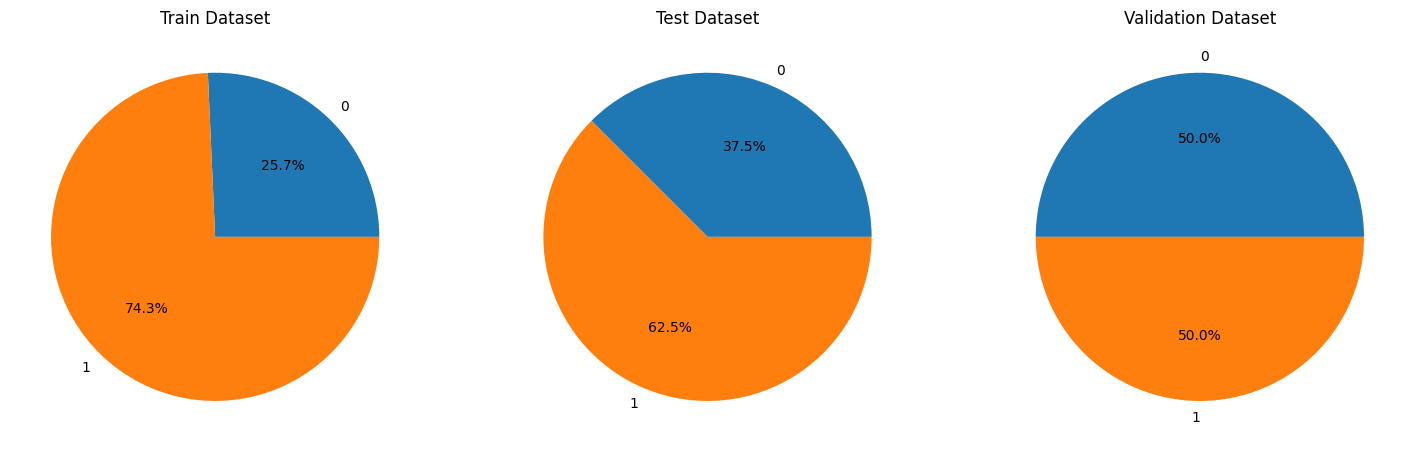

In [11]:
import matplotlib.pyplot as plt

# Function to compute class distribution from a DataLoader
def compute_class_distribution(data_loader):
    class_distribution = {}
    for _, labels in data_loader:
        for label in labels:
            class_distribution[label.item()] = class_distribution.get(label.item(), 0) + 1
    return class_distribution

# Compute class distributions
train_class_distribution = compute_class_distribution(train_loader)
test_class_distribution = compute_class_distribution(test_loader)
val_class_distribution = compute_class_distribution(val_loader)

# Plotting pie charts
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Train dataset
axs[0].pie(train_class_distribution.values(), labels=train_class_distribution.keys(), autopct='%1.1f%%')
axs[0].set_title('Train Dataset')

# Test dataset
axs[1].pie(test_class_distribution.values(), labels=test_class_distribution.keys(), autopct='%1.1f%%')
axs[1].set_title('Test Dataset')

# Validation dataset
axs[2].pie(val_class_distribution.values(), labels=val_class_distribution.keys(), autopct='%1.1f%%')
axs[2].set_title('Validation Dataset')

plt.show()


In [13]:
class ConvNet(nn.Module):
  def __init__(self,num_classes=2):
    super(ConvNet,self).__init__()
    self.conv1 =nn.Conv2d(in_channels=1,out_channels=5,kernel_size=5,stride=1,padding=2) # outptu channels is the number of kernels used
    self.bn1 = nn.BatchNorm2d(num_features=5)
    self.sigmoid1 = nn.Sigmoid()

    #256*20*80*80
    self.conv2 = nn.Conv2d(in_channels=5,out_channels = 16,kernel_size =5,stride=1,padding=2)
    self.bn2=nn.BatchNorm2d(num_features=16)
    self.pool1=nn.MaxPool2d(kernel_size=2)
    self.sigmoid2 = nn.Sigmoid()

    self.conv3 = nn.Conv2d(in_channels=16,out_channels =32,kernel_size =3,stride =1 ,padding=1)
    self.bn3 = nn.BatchNorm2d(num_features=32)
    self.dropout1 = nn.Dropout(0.2)
    self.sigmoid3 =nn.Sigmoid()
    
    self.conv4 = nn.Conv2d(in_channels=32,out_channels =50,kernel_size =3,stride =1 ,padding=1)
    self.bn4 = nn.BatchNorm2d(num_features=50)
    self.pool2=nn.MaxPool2d(kernel_size=2)
    self.sigmoid4 =nn.Sigmoid()
    
    self.conv5 = nn.Conv2d(in_channels=50,out_channels =70,kernel_size =3,stride =1 ,padding=1)
    self.bn5 = nn.BatchNorm2d(num_features=70)
    self.sigmoid5 =nn.Sigmoid()


    self.fc = nn.Linear(in_features=70*40*40,out_features = 2)

  def forward(self,input):
    output = self.conv1(input)
    output = self.bn1(output)
    output = self.sigmoid1(output)
    
    output = self.conv2(output)
    output = self.bn2(output)
    output = self.pool1(output)
    output = self.sigmoid2(output)
    
    output = self.conv3(output)
    output = self.bn3(output)
    output = self.sigmoid3(output)
    
    output = self.conv4(output)
    output = self.bn4(output)
    output = self.pool2(output)
    output = self.sigmoid4(output)
    
    output = self.conv5(output)
    output = self.bn5(output)
    output = self.sigmoid5(output)

    output = output.view(-1,70*40*40)
    output = self.fc(output)
    return output




In [19]:
import torch.optim as optim
model = ConvNet(num_classes=2).to(device)
# optimizer =Adam(model.parameters(),lr = 0.1,weight_decay=0.0002)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=0.0002)
num_epochs =20

Weighted Loss function:

In [16]:
weight_for_class_normal = 5291 / (1341 * 2)
weight_for_class_pneumonia = 5291 / (3875 * 2)

class_weights_tensor = torch.tensor([weight_for_class_normal, weight_for_class_pneumonia], dtype=torch.float32)
class_weights_tensor = class_weights_tensor.to(device)


# weighted loss function using to ensure that the model gives prority to the normal samples as well
#although they are much lesser in quantity
weighted_loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor)

Epoch: 0, Train Loss: 5.8808, Train Accuracy: 0.6235, Validation Accuracy: 0.5000
Epoch: 1, Train Loss: 0.4342, Train Accuracy: 0.8618, Validation Accuracy: 0.6250
Epoch: 2, Train Loss: 0.4116, Train Accuracy: 0.8641, Validation Accuracy: 0.7500
Epoch: 3, Train Loss: 0.3151, Train Accuracy: 0.8831, Validation Accuracy: 0.5000
Epoch: 4, Train Loss: 0.4390, Train Accuracy: 0.8694, Validation Accuracy: 0.8125
Epoch: 5, Train Loss: 0.2220, Train Accuracy: 0.9147, Validation Accuracy: 0.7500
Epoch: 6, Train Loss: 0.2173, Train Accuracy: 0.9112, Validation Accuracy: 0.8125
Epoch: 7, Train Loss: 0.2032, Train Accuracy: 0.9174, Validation Accuracy: 0.7500
Epoch: 8, Train Loss: 0.1991, Train Accuracy: 0.9189, Validation Accuracy: 0.8125
Epoch: 9, Train Loss: 0.1819, Train Accuracy: 0.9277, Validation Accuracy: 0.5625
Epoch: 10, Train Loss: 0.2211, Train Accuracy: 0.9128, Validation Accuracy: 0.6875
Epoch: 11, Train Loss: 0.1756, Train Accuracy: 0.9285, Validation Accuracy: 0.8750
Epoch: 12, Tra

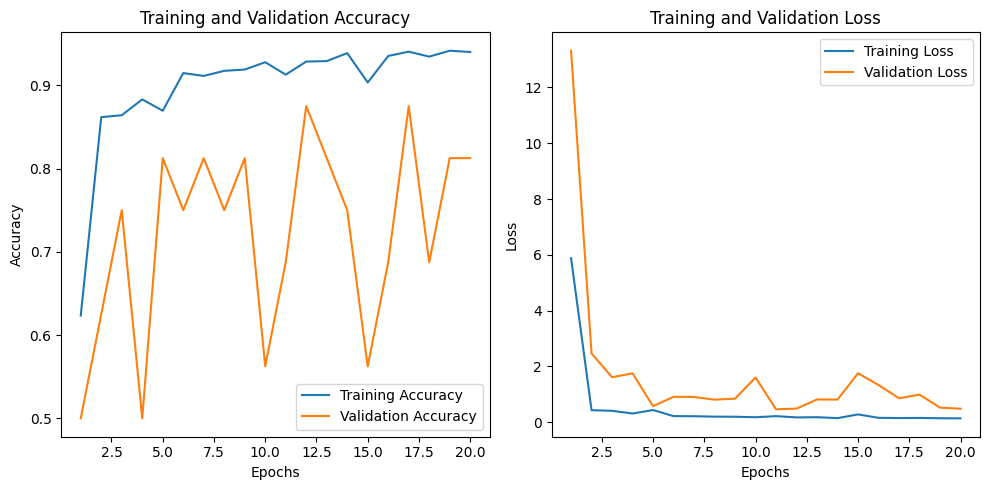

In [20]:
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(model, train_loader, optimizer, weighted_loss_function, device):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss = weighted_loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        not_used, prediction = torch.max(outputs.data, 1)
        train_accuracy += torch.sum(prediction == labels.data).item()

    train_accuracy = train_accuracy / len(train_loader.dataset)
    train_loss = train_loss / len(train_loader.dataset)

    return train_accuracy, train_loss

def test(model, test_loader, device):
    model.eval()
    test_accuracy = 0.0
    test_loss = 0.0
    total_images_test = len(test_loader.dataset)

    for i, (images, labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        loss = weighted_loss_function(outputs, labels)
        test_loss += loss.cpu().data * images.size(0)
        not_used, prediction = torch.max(outputs.data, 1)
        test_accuracy += int(torch.sum(prediction == labels.data))

    test_accuracy = test_accuracy / total_images_test
    test_loss = test_loss / total_images_test

    return test_accuracy, test_loss


train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

best_accuracy = 0.0


for epoch in range(num_epochs):
    train_accuracy, train_loss = train(model, train_loader, optimizer, weighted_loss_function, device)
    val_accuracy,val_loss = test(model, val_loader, device)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print('Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}'.format(epoch, train_loss, train_accuracy, val_accuracy))

    # Save the best model
    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), '/kaggle/working/Best_model_CNN1_Sig_adagrad_128_0.001.pt')
        best_accuracy = val_accuracy


plt.figure(figsize=(10, 5))

#for accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#for loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
model_path = '/kaggle/working/Best_model_CNN1_Sig_adagrad_128_0.001.pt'
state_dict = torch.load(model_path,map_location=device)
# Load the state dictionary into the model
model.load_state_dict(state_dict)
model.to(device)

# Set the model to evaluation mode
model.eval()

total_correct = 0
total_images_test = len(test_loader.dataset)
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == targets).sum().item()

accuracy = total_correct / total_images_test
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 88.46%
